<a href="https://colab.research.google.com/github/joaopamaral/tcc_puc_cdbd/blob/master/EDA_TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise Exploratória dos dados - Reducing Commercial Aviation Fatalities

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling as pp
import seaborn as sns
import sys
import os
import math

IN_COLAB = 'google.colab' in sys.modules

%matplotlib inline
plt.style.use('ggplot')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
gdrive_kaggle_dir = '/gdrive/My Drive/Kaggle'
api_gdrive_credential_location = f'{gdrive_kaggle_dir}/kaggle.json'
data_gdrive_dir = f'{gdrive_kaggle_dir}/reducing-commercial-aviation-fatalities'
api_local_credential_location = os.path.join(os.path.expanduser('~'), '.kaggle/kaggle.json')

In [3]:
if IN_COLAB:
    if not os.path.isfile('train.csv.zip') or not os.path.isfile('test.csv.zip'):
        from google.colab import drive
        drive.mount('/gdrive')

        if os.path.isdir(gdrive_kaggle_dir):
            if os.path.isfile(f'{data_gdrive_dir}/test.csv.zip') and os.path.isfile(f'{data_gdrive_dir}/train.csv.zip'):
                !cp '{data_gdrive_dir}/train.csv.zip' .
                !cp '{data_gdrive_dir}/test.csv.zip' .
            else:
                !mkdir -p ~/.kaggle
                !cp '{api_gdrive_credential_location}' '{api_local_credential_location}'

if not os.path.isfile('train.csv.zip') or not os.path.isfile('test.csv.zip'):
    if os.path.isfile(api_local_credential_location):
        !pip -q install kaggle --upgrade
        !kaggle competitions download -c reducing-commercial-aviation-fatalities
        if IN_COLAB and os.path.isdir(gdrive_kaggle_dir):
            !cp train.csv.zip '{data_gdrive_dir}'
            !cp test.csv.zip '{data_gdrive_dir}'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
raw_train_df = pd.read_csv('train.csv.zip')

In [5]:
raw_train_df.head()

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event
0,1,CA,0.011719,1,-5.28545,26.775801,-9.527310,-12.793200,16.717800,33.737499,23.712299,-6.695870,29.232100,24.842899,3.92134,18.447001,1.07547,3.09029,37.368999,17.437599,19.201900,20.5968,-3.95115,14.507600,-4520.0,817.705994,388.829987,A
1,1,CA,0.015625,1,-2.42842,28.430901,-9.323510,-3.757230,15.969300,30.443600,21.010300,-6.474720,26.641399,24.138800,5.46991,20.510599,2.83354,7.10177,31.170799,19.399700,19.689501,21.3547,1.33212,17.750200,-4520.0,817.705994,388.829987,A
2,1,CA,0.019531,1,10.67150,30.420200,15.350700,24.724001,16.143101,32.142799,25.431801,-0.088707,28.119900,26.891300,8.57886,23.162901,4.51993,12.70550,-12.012600,19.396299,23.171700,22.4076,1.53786,22.247000,-4520.0,817.705994,388.829987,A
3,1,CA,0.023438,1,11.45250,25.609800,2.433080,12.412500,20.533300,31.494101,19.142799,-0.256516,30.653601,24.247000,8.64310,19.961901,7.27575,11.45980,18.574100,23.156401,22.641199,19.3367,2.54492,18.998600,-4520.0,817.705994,388.829987,A
4,1,CA,0.027344,1,7.28321,25.942600,0.113564,5.748000,19.833599,28.753599,20.572100,-1.953470,31.722601,25.155500,12.50030,18.746901,7.30976,8.00805,6.555440,22.754700,22.670300,20.2932,1.69962,22.812799,-4520.0,817.705994,388.829987,A


In [6]:
raw_train_df.describe(include='all')

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event
count,4.867421e+06,4867421,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4867421
unique,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
top,NaN,DA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A
freq,NaN,1658393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2848809
mean,5.538783e+00,NaN,1.782358e+02,4.999531e-01,3.746336e+00,1.360002e+00,1.213644e+00,7.350926e-02,7.845481e-02,8.675488e-02,2.299909e-01,3.627284e+00,1.836475e-01,2.650569e-01,4.407218e-01,1.385392e+00,1.316266e+00,1.208597e+00,6.050047e-01,2.413972e-01,1.947635e-01,6.243715e-01,4.429119e-01,2.393738e-01,5.285460e+03,7.376090e+02,8.518467e+02,NaN
std,3.409353e+00,NaN,1.039592e+02,5.000000e-01,4.506763e+01,3.518923e+01,3.519242e+01,2.431472e+01,1.803932e+01,1.832606e+01,2.531132e+01,4.615674e+01,2.807377e+01,1.658195e+01,6.410874e+01,4.284167e+01,5.481694e+01,4.205516e+01,2.052105e+01,1.660196e+01,1.833801e+01,1.975695e+01,1.974815e+01,2.351859e+01,1.214126e+04,8.187979e+01,5.039324e+02,NaN
min,1.000000e+00,NaN,3.000000e-03,0.000000e+00,-1.361360e+03,-1.581330e+03,-1.643950e+03,-1.516640e+03,-1.220510e+03,-1.266430e+03,-1.279940e+03,-1.393480e+03,-2.887910e+03,-1.226780e+03,-2.875940e+03,-1.353410e+03,-4.064070e+03,-2.333830e+03,-1.212030e+03,-1.228030e+03,-1.229130e+03,-1.230480e+03,-6.962790e+02,-1.176370e+03,-1.858570e+04,4.820600e+02,0.000000e+00,NaN
25%,3.000000e+00,NaN,8.808100e+01,0.000000e+00,-9.200250e+00,-8.325150e+00,-8.767610e+00,-7.367240e+00,-6.102000e+00,-6.007260e+00,-6.904030e+00,-9.575000e+00,-6.657340e+00,-6.580460e+00,-7.643640e+00,-9.285550e+00,-8.055440e+00,-9.306430e+00,-7.495970e+00,-6.713860e+00,-6.774840e+00,-7.161160e+00,-7.817650e+00,-6.526950e+00,-2.550070e+03,6.631430e+02,5.241140e+02,NaN
50%,5.000000e+00,NaN,1.769297e+02,0.000000e+00,3.819020e-01,4.264100e-02,1.140390e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.893450e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.170790e-01,1.106700e-01,5.667500e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.920510e+03,7.434380e+02,7.701970e+02,NaN
75%,7.000000e+00,NaN,2.683398e+02,1.000000e+00,1.030610e+01,8.753340e+00,9.282560e+00,7.437780e+00,6.176630e+00,6.086460e+00,7.071460e+00,1.062990e+01,6.781080e+00,6.744350e+00,7.810010e+00,9.955490e+00,8.631610e+00,9.775770e+00,7.765670e+00,6.831320e+00,6.905020e+00,7.466520e+00,8.025190e+00,6.615180e+00,1.029010e+04,8.134120e+02,1.197120e+03,NaN


In [7]:
raw_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4867421 entries, 0 to 4867420
Data columns (total 28 columns):
 #   Column      Dtype  
---  ------      -----  
 0   crew        int64  
 1   experiment  object 
 2   time        float64
 3   seat        int64  
 4   eeg_fp1     float64
 5   eeg_f7      float64
 6   eeg_f8      float64
 7   eeg_t4      float64
 8   eeg_t6      float64
 9   eeg_t5      float64
 10  eeg_t3      float64
 11  eeg_fp2     float64
 12  eeg_o1      float64
 13  eeg_p3      float64
 14  eeg_pz      float64
 15  eeg_f3      float64
 16  eeg_fz      float64
 17  eeg_f4      float64
 18  eeg_c4      float64
 19  eeg_p4      float64
 20  eeg_poz     float64
 21  eeg_c3      float64
 22  eeg_cz      float64
 23  eeg_o2      float64
 24  ecg         float64
 25  r           float64
 26  gsr         float64
 27  event       object 
dtypes: float64(24), int64(2), object(2)
memory usage: 1.0+ GB


In [8]:
raw_train_df.isna().sum()

crew          0
experiment    0
time          0
seat          0
eeg_fp1       0
eeg_f7        0
eeg_f8        0
eeg_t4        0
eeg_t6        0
eeg_t5        0
eeg_t3        0
eeg_fp2       0
eeg_o1        0
eeg_p3        0
eeg_pz        0
eeg_f3        0
eeg_fz        0
eeg_f4        0
eeg_c4        0
eeg_p4        0
eeg_poz       0
eeg_c3        0
eeg_cz        0
eeg_o2        0
ecg           0
r             0
gsr           0
event         0
dtype: int64

In [0]:
train_df = raw_train_df.set_index(['crew', 'experiment', 'seat', 'time'])

In [10]:
train_df.index.duplicated().sum()

0

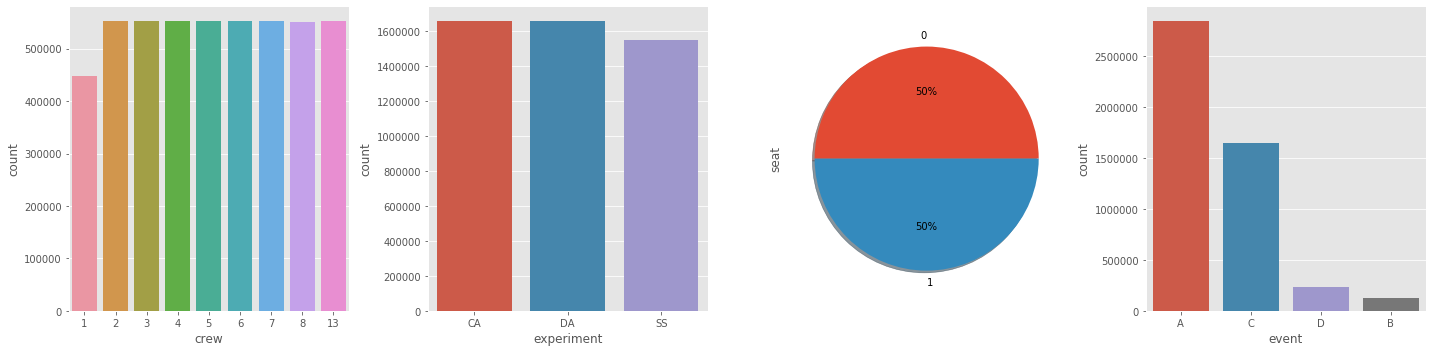

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(20,5))

sns.countplot(train_df.index.get_level_values('crew'), ax=ax[0]);
sns.countplot(train_df.index.get_level_values('experiment'), ax=ax[1]);
train_df.index.get_level_values('seat').value_counts().plot.pie(autopct='%.0f%%', shadow=True, ax=ax[2]);
sns.countplot(train_df.event, ax=ax[3]);

fig.tight_layout()

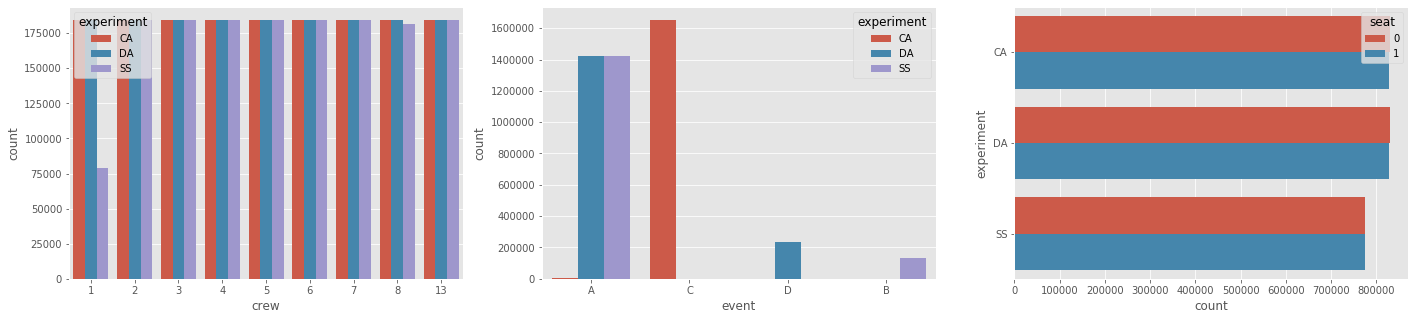

In [51]:
fig, ax = plt.subplots(1, 3, figsize=(24,5))

sns.countplot(x="crew", hue="experiment", data=train_df.reset_index(), ax=ax[0]);
sns.countplot(x="event", hue="experiment", data=train_df.reset_index(), ax=ax[1]);
sns.countplot(y="experiment", hue="seat", data=train_df.reset_index(), ax=ax[2]);

In [0]:
eeg_columns = ['eeg_fp1', 'eeg_f7', 'eeg_f8', 'eeg_t4', 'eeg_t6', 
               'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3', 
               'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4',	'eeg_c4', 
               'eeg_p4', 'eeg_poz', 'eeg_c3', 'eeg_cz', 'eeg_o2']

numeric_features = [*eeg_columns, 'ecg', 'r', 'gsr']
categorical_feature = ['event']

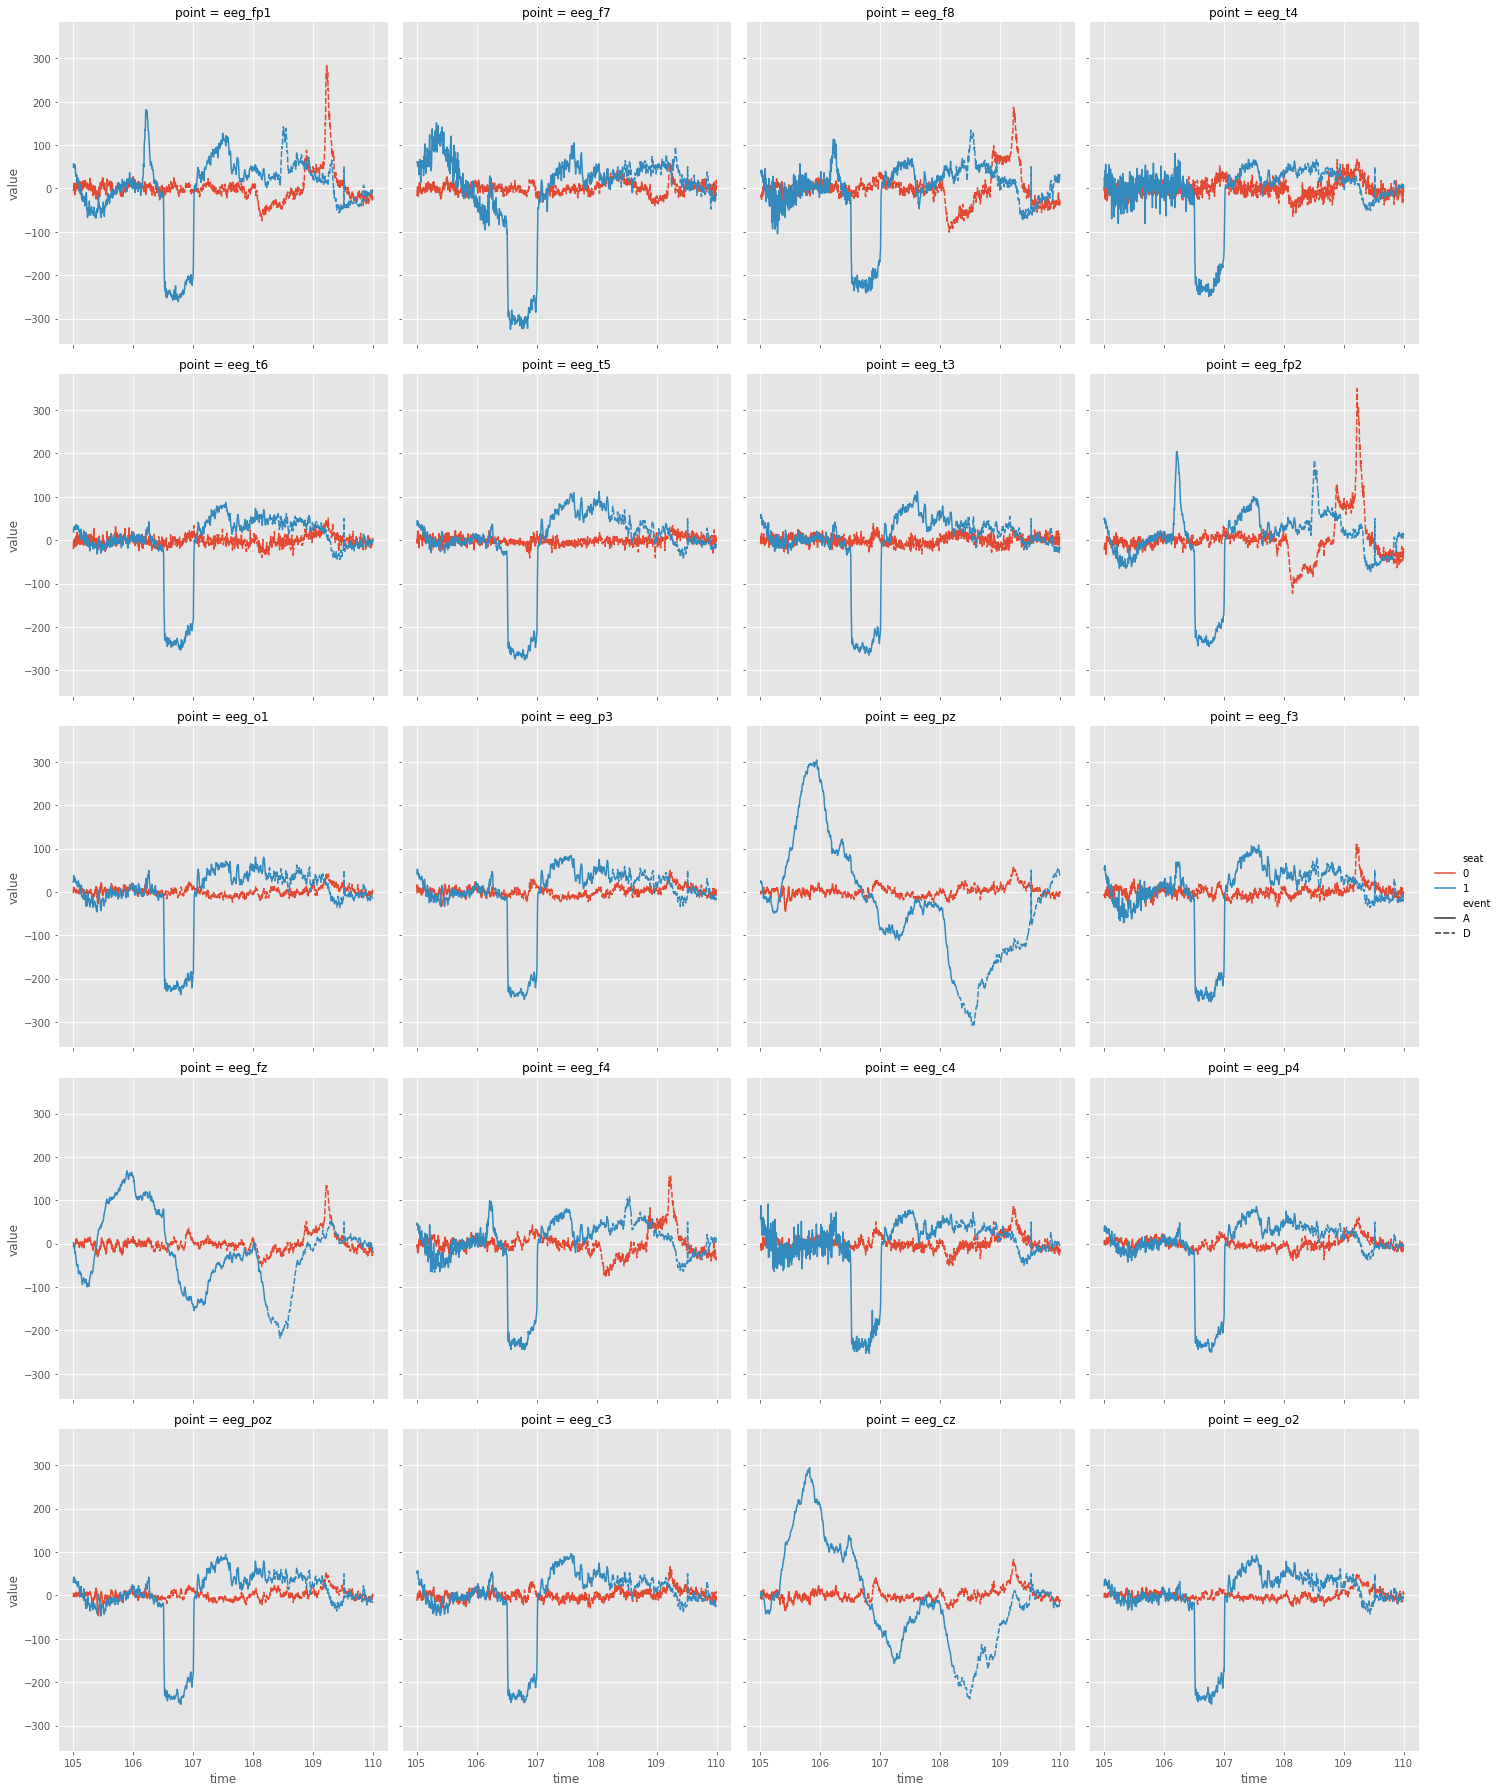

In [81]:
def plot_eeg(crew='1', experiment='DA', start_time=105, end_time=110):
    sns.relplot(x="time", y='value', col="point", kind='line', col_wrap=4, hue='seat', style='event',
                data=train_df.reset_index().query(f'crew == {crew} & experiment == "{experiment}" & time > {start_time} & time < {end_time}')
                .loc[:, ['time', 'event', 'seat', *eeg_columns]].set_index(['time', 'event', 'seat'])
                .stack().reset_index().rename(columns={'level_3': 'point', 0: 'value'}))
    
plot_eeg()

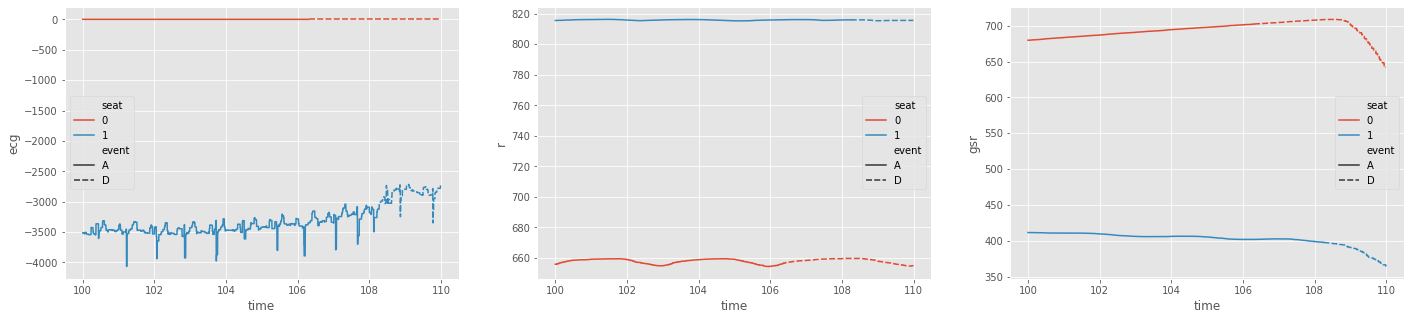

In [78]:
def plot_ecg_r_gsr(crew='1', experiment='DA', start_time=100, end_time=110):
    fig, ax = plt.subplots(1, 3, figsize=(24,5))

    filtered_data = train_df.reset_index().query(f'crew == {crew} & experiment == "{experiment}" & time > {start_time} & time < {end_time}')

    sns.lineplot(x="time", y="ecg", hue='seat', style='event', data=filtered_data, ax=ax[0])
    sns.lineplot(x="time", y="r", hue='seat', style='event', data=filtered_data, ax=ax[1])
    sns.lineplot(x="time", y="gsr", hue='seat', style='event', data=filtered_data, ax=ax[2])
    
plot_ecg_r_gsr()

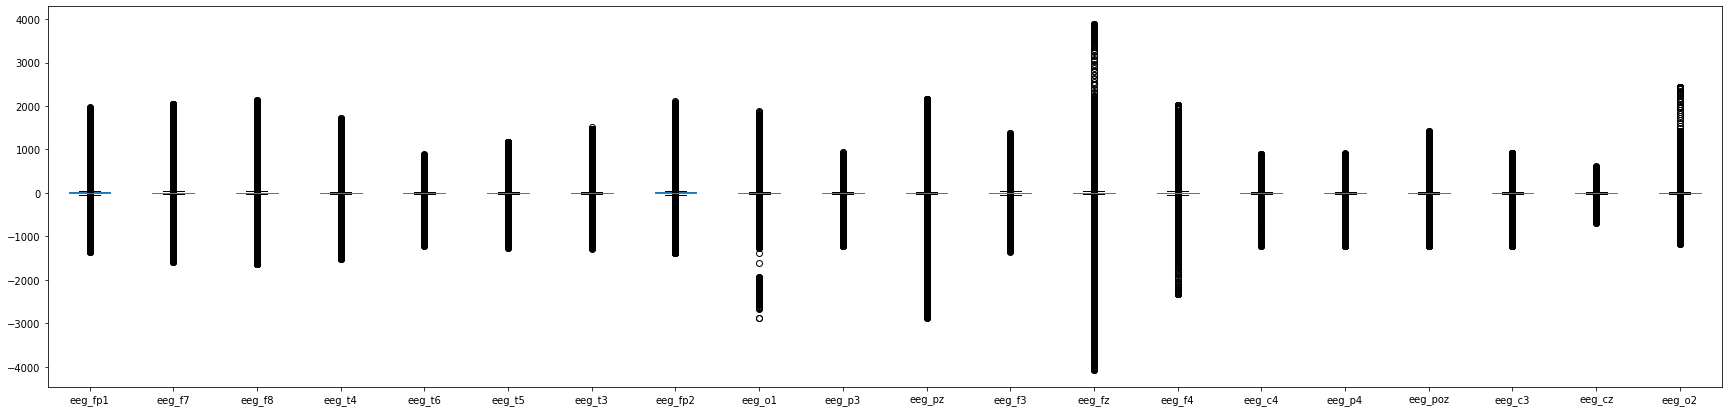

In [0]:
train_df.loc[:, train_df.columns.str.contains('eeg')].plot.box(figsize=(30,7));

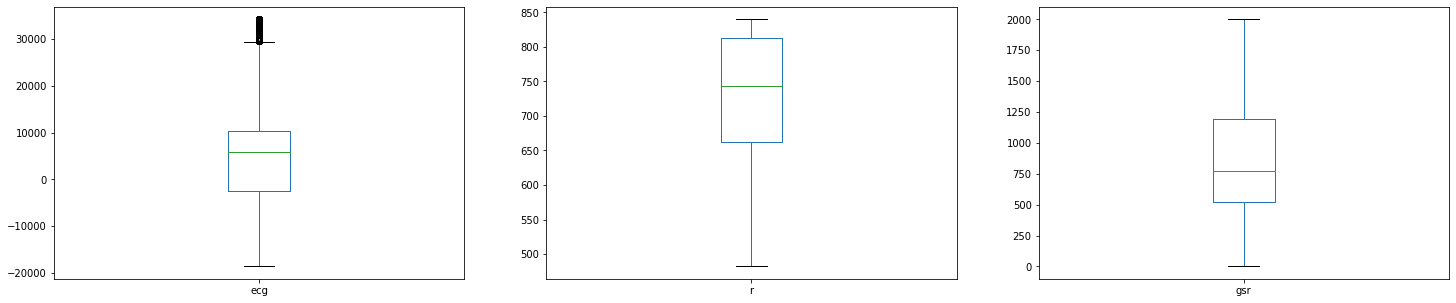

In [0]:
fig, ax = plt.subplots(1, 3, figsize=(25,5))

train_df['ecg'].plot.box(ax=ax[0]);
train_df['r'].plot.box(ax=ax[1]);
train_df['gsr'].plot.box(ax=ax[2]);

In [0]:
# pp.ProfileReport(train_df).to_file("report-reducing-commercial-aviation-fatalities.html")

In [0]:
train_df = train_df.drop_duplicates()

![alt text](https://scikit-learn.org/stable/_static/ml_map.png)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [0]:
features = [*train_df.columns[train_df.columns.str.contains('eeg')], 'ecg', 'r', 'gsr']
target = 'distraction'

X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_df[target], test_size=0.30, random_state=42, stratify=train_df[target])

In [0]:
print(f'Quantidade de dados de treinamento: {y_train.shape[0]}')
print(f'Quantidade de dados de teste: {X_test.shape[0]}')

Quantidade de dados de treinamento: 3406701
Quantidade de dados de teste: 1460015


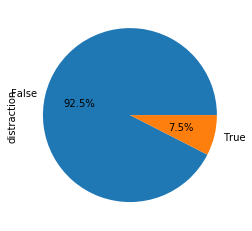

In [0]:
y_train.value_counts().plot.pie(autopct='%1.1f%%');

In [0]:
def show_metrics(model, X_test, y_test, labels=['Not Distracted', 'Distracted']):
    fig, ax = plt.subplots(2, 2, figsize=(10, 7))

    plot_confusion_matrix(model, X_test, y_test, display_labels=labels, cmap=plt.cm.Blues, ax=ax[0, 0])
    ax[0, 0].set_title('Confusion matrix, without normalization')

    plot_confusion_matrix(model, X_test, y_test, display_labels=labels, cmap=plt.cm.Blues, normalize='true', ax=ax[0, 1])
    ax[0, 1].set_title('Normalized confusion matrix')

    disp = plot_precision_recall_curve(model, X_test, y_test, ax=ax[1, 0])
    ax[1, 0].set_title('Precision-Recall Curve')

    plot_roc_curve(model, X_test, y_test, ax=ax[1, 1])
    ax[1, 1].set_title('ROC Curve')

    plt.tight_layout()
    plt.show()

    y_predict = model.predict(X_test)

    display(pd.DataFrame(classification_report(y_test, y_predict, output_dict=True)).T)

In [0]:
sgd_model = make_pipeline(StandardScaler(),
                          SGDClassifier(n_jobs=-1, class_weight='balanced')) # verbose=1)
sgd_model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('sgdclassifier',
                 SGDClassifier(alpha=0.0001, average=False,
                               class_weight='balanced', early_stopping=False,
                               epsilon=0.1, eta0=0.0, fit_intercept=True,
                               l1_ratio=0.15, learning_rate='optimal',
                               loss='hinge', max_iter=1000, n_iter_no_change=5,
                               n_jobs=-1, penalty='l2', power_t=0.5,
                               random_state=None, shuffle=True, tol=0.001,
                               validation_fraction=0.1, verbose=0,
                               warm_start=False))],
         verbose=False)

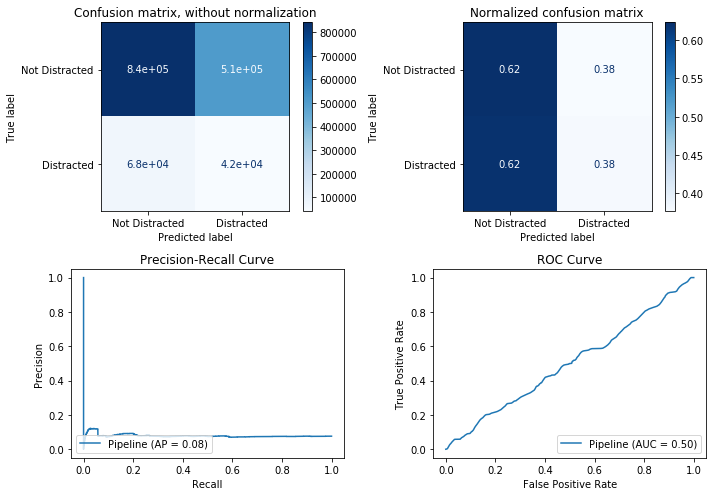

,precision,recall,f1-score,support
False,0.925067,0.623169,0.744684,1.350247e+06
True,0.075596,0.379072,0.126054,1.097680e+05
accuracy,0.604817,0.604817,0.604817,6.048171e-01
macro avg,0.500332,0.501121,0.435369,1.460015e+06
weighted avg,0.861202,0.604817,0.698173,1.460015e+06


In [0]:
show_metrics(sgd_model, X_test, y_test)

In [0]:
lr_model = make_pipeline(StandardScaler(),
                         LogisticRegressionCV(cv=5, n_jobs=-1, class_weight='balanced'))
lr_model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregressioncv',
                 LogisticRegressionCV(Cs=10, class_weight='balanced', cv=5,
                                      dual=False, fit_intercept=True,
                                      intercept_scaling=1.0, l1_ratios=None,
                                      max_iter=100, multi_class='auto',
                                      n_jobs=-1, penalty='l2',
                                      random_state=None, refit=True,
                                      scoring=None, solver='lbfgs', tol=0.0001,
                                      verbose=0))],
         verbose=False)

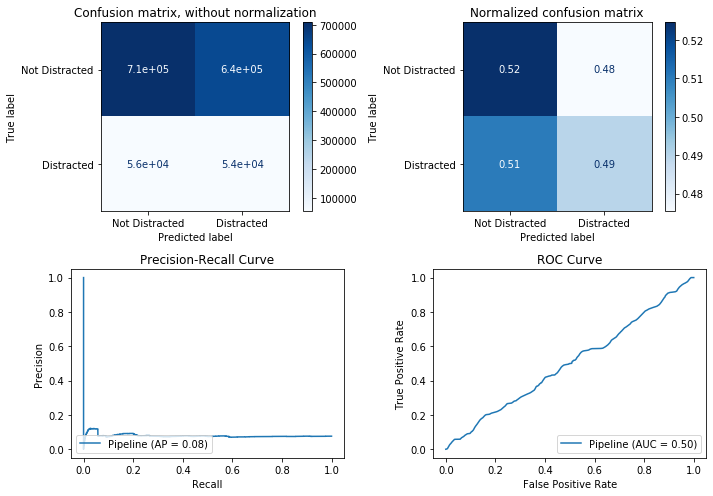

,precision,recall,f1-score,support
False,0.926707,0.524571,0.669925,1.350247e+06
True,0.077259,0.489660,0.133461,1.097680e+05
accuracy,0.521946,0.521946,0.521946,5.219460e-01
macro avg,0.501983,0.507115,0.401693,1.460015e+06
weighted avg,0.862843,0.521946,0.629592,1.460015e+06


In [0]:
show_metrics(lr_model, X_test, y_test)

In [0]:
rf_model = RandomForestClassifier(n_jobs=-1)
rf_model.fit(X_train, y_train)

In [0]:
show_metrics(rf_model, X_test, y_test)